Testing CNN method from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=%EF%BB%BFKeras%20is%20a%20go,both%20beginners%20and%20advanced%20users.

https://keras.io/guides/sequential_model/

In [70]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers # example functions: Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras import Input
import matplotlib.pyplot as plt
import time

In [72]:
def get_data(audio_path, meta_file, label_name, load_length):
    songs_matrix = []
    songs_label = []
    audio_list = os.listdir(audio_path)
    df = pd.read_csv(meta_file)

    for name in audio_list:
        # parse out number part of the data files so we can get the corresponding label from meta_file
        number = name.replace('_', '.').split('.')[0]
        filepath = os.path.join(audio_path, name)
        # skipping files that are less than 250KB ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < 250000:
            continue
        # ============ load the data and get matrix ============
        # replace this block with function that cleansup data and outputs a feature matrix per file
        # make sure that the size of the feature matrix is the same for all files
        # name the output feature matrix mfccs 
        song, sr = librosa.load(filepath, duration=load_length)
        mfccs = librosa.feature.mfcc(y = song, n_mfcc = 40)#, n_fft=512)

        #mfcc = np.mean(mfccs, axis=1) # average over columns, shape(n_mfcc, ), used for vector input data
        # ======================================================
        songs_matrix.append(mfccs)
        songs_label.append(df[label_name].loc[df.cat_num == float(number)].item())
    return np.array(songs_matrix), np.array(songs_label)

In [73]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table
    # append as value the correspondign label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_divison])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_divison][idx]
    return [lookup_table[label] for label in labels]

# example testing block
#from_division = 'fam_or_subfam'
#to_division = 'critter_name'
#meta_file = 'MLNS_Insects_Fams_05212024.csv'
#labels = ['Acrididae', 'Cicadidae', 'Acrididae', 'Listroscelidinae', 
#                  'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',
#                  'Phaneropterinae', 'Oecanthinae', 'Tettigoniinae','Trigonidiinae']    
#convert_labels(labels, meta_file, from_division, to_division)

In [74]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_Insects_Fams_05212024.csv'
label_name = 'fam_or_subfam'
start = time.time()
max_time = 5 # cut off time for loading, in sec
songs_matrix, songs_label = get_data(audio_path, meta_file, label_name, max_time)
end = time.time()
print('time loading:', end - start)

time loading: 51.27629542350769


In [75]:
songs_matrix.shape
print(np.unique(songs_label, return_counts=True))

(array(['Acrididae', 'Cicadidae', 'Conocephalinae', 'Eneopterinae',
       'Gryllinae', 'Gryllotalpidae', 'Hapithinae', 'Listroscelidinae',
       'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',
       'Phaneropterinae', 'Pseudophyllinae', 'Tettigoniinae',
       'Trigonidiinae'], dtype='<U16'), array([   1,   56,  828,   31, 1400,   42,  374,   10,  336,  370,  743,
         12,  557,  140,  256,  545], dtype=int64))


In [76]:
# remove classes with too few data points
delete_list = list(np.where(songs_label=='Acrididae')[0])+list(np.where(songs_label=='Listroscelidinae')[0])+list(np.where(songs_label=='Phalangopsidae')[0])

short_label = np.delete(songs_label, delete_list)
short_matrix = np.delete(songs_matrix, delete_list, 0)
# double check data after deleting
print(np.unique(short_label, return_counts=True))

(array(['Cicadidae', 'Conocephalinae', 'Eneopterinae', 'Gryllinae',
       'Gryllotalpidae', 'Hapithinae', 'Mogoplistinae', 'Nemobiinae',
       'Oecanthinae', 'Phaneropterinae', 'Pseudophyllinae',
       'Tettigoniinae', 'Trigonidiinae'], dtype='<U16'), array([  56,  828,   31, 1400,   42,  374,  336,  370,  743,  557,  140,
        256,  545], dtype=int64))


In [77]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(short_label)
songs_label_onehot = to_categorical(songs_label_num) # required output format by cnn

# rename data/label variable name so that we don't need to change them in the model block
data_matrix = short_matrix
data_label = songs_label_onehot

In [111]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, data_label, 
                                                    test_size = .2, random_state = 404)
# to use 2d convolution, keras model expects 4d input shape
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
print(X_train.shape)


(4542, 40, 216, 1)


In [79]:
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 202)
print(X_tt.shape, y_tt.shape)

(3633, 40, 216, 1) (3633, 13)


In [81]:
# make model 
input_shape =  (X_tt.shape[1], X_tt.shape[2],1,) # first dimension of train data is n_datapoints
model = Sequential() 
model.add(Input(input_shape))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
#model.add(layers.Dropout(0.2))
#model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
#model.add(layers.MaxPooling2D((2,2), strides=2))
#model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(le.classes_), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [82]:
# train model
start = time.time()
epochs = 10
history = model.fit(X_tt, y_tt, epochs=epochs, batch_size=64, validation_data=(X_val, y_val))
end = time.time()
print('time training: ', end - start)
#predicted_vector = model.predict(X_test)
#predicted_class_index = np.argmax(predicted_vector, axis=-1)
#le.inverse_transform(predicted_class_index)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.2274 - loss: 244.6542 - val_accuracy: 0.4092 - val_loss: 12.7564
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4874 - loss: 7.7030 - val_accuracy: 0.5182 - val_loss: 2.9862
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6014 - loss: 2.0789 - val_accuracy: 0.5171 - val_loss: 2.8981
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6401 - loss: 1.3658 - val_accuracy: 0.5336 - val_loss: 1.7896
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.7081 - loss: 0.9641 - val_accuracy: 0.5424 - val_loss: 1.8258
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.6564 - loss: 1.1432 - val_accuracy: 0.5567 - val_loss: 1.5902
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.7760 - loss: 0.6279 - val_accuracy: 0.5457 - val_loss: 1.7066
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8542 - loss: 0.4569 - val_accuracy:

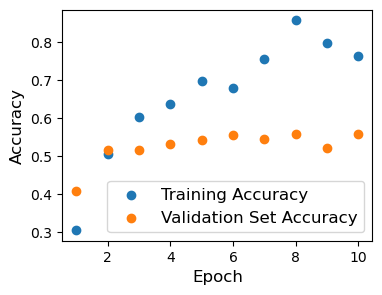

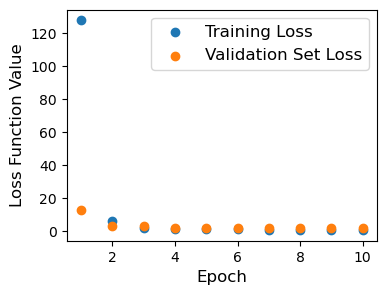

In [83]:
history_dict = history.history
plt.figure(figsize = (4, 3))
epochs = 10
plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (4, 3))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [88]:
predicted_vector = model.predict(X_test)
predicted_class_index = np.argmax(predicted_vector, axis=-1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [91]:
pred_class = le.inverse_transform(predicted_class_index)

In [121]:
true_class_idx = np.where(y_test.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
print(true_class)

['Gryllinae' 'Tettigoniinae' 'Trigonidiinae' ... 'Trigonidiinae'
 'Gryllinae' 'Nemobiinae']


In [136]:
conf_mat = confusion_matrix(true_class, pred_class)
print(pd.DataFrame(conf_mat))#,
#                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
#                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

    0   1   2    3   4   5   6   7    8   9   10  11  12
0    1   4   1    0   1   2   0   0    7   0   0   0   1
1    1  99   0    2   0  16   1   4   13  18   2  12   6
2    0   0   0    0   0   1   0   0    1   1   0   0   1
3    0   6   0  218   0   4   8   1   19   5   4   0   1
4    0   0   0    0   0   0   0   0    3   1   1   0   1
5    0   2   1    6   0  40   6   3    3   4   7   1   5
6    0   2   0    5   0   3  38   1    0   0   5   2   6
7    0  10   0    8   0   8   4  15    3   2   2   0  21
8    1   3   0    4   0   1   2   0  133   4   5   0   0
9    0  16   1    0   1   5   0   0   15  65   0   9   1
10   0   1   0    0   2   7   1   1    1   4   8   0   0
11   0  15   0    0   0   2   0   1    5  27   4   4   0
12   0   4   0   10   0  11  16  14    4   0   2   1  45
accuracy = 0.5862676056338029


In [124]:
## to shorte list of classes after fitting on long list, use the class converter. 
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')

In [135]:
conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

   0    1    2
0  1   12    4
1  1  674   74
2  1   85  284
accuracy= 0.8441901408450704
